In [1]:

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torchvision
import torch
import numpy as np
from torch import manual_seed
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay



Classes: ['Alaxan', 'Bactidol', 'Bioflu', 'Biogesic', 'DayZinc', 'Decolgen', 'Fish Oil', 'Kremil S', 'Medicol', 'Neozep']


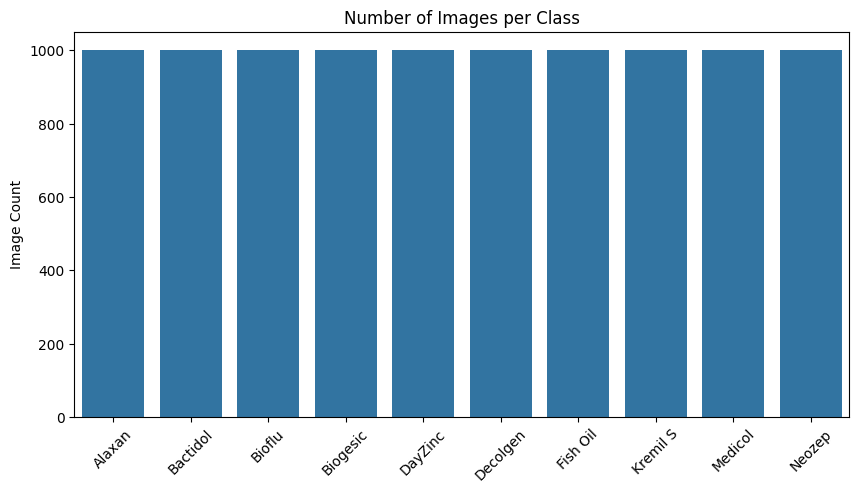

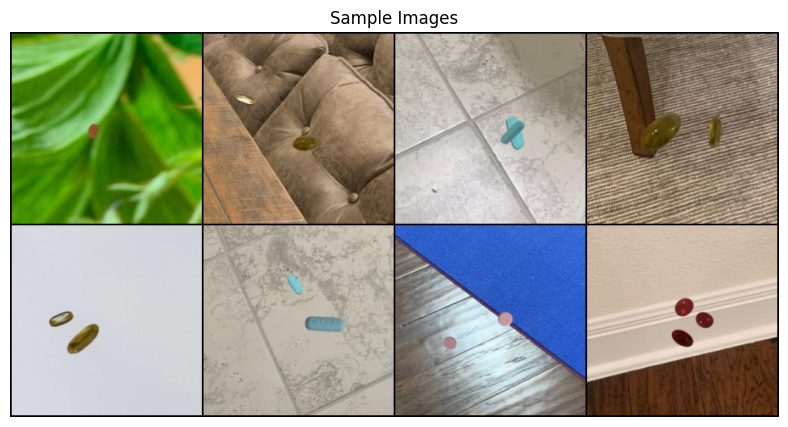

In [2]:
# -------------------------
#Dataset Setup
# -------------------------
SEED = 42
torch.manual_seed(SEED)
data_path = r'c:\Users\suman\Desktop\Masters  Courses\Advanced Program\Advance Programming 11 projects\GROUP2\GROUP2\Pharmaceutical Image Classification\Pharmaceutical Image Classification\pharmaceutical_dataset\Drug Vision\Data Combined'
img_size = 224
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# Load the dataset with labels inferred from folder names
dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = dataset.classes
class_to_idx = dataset.class_to_idx
print("Classes:", class_names)

# Count images per class
label_counts = {label: 0 for label in class_names}
for _, label in dataset:
    label_counts[class_names[label]] += 1

# Plot image count per class
plt.figure(figsize=(10, 5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.ylabel("Image Count")
plt.show()

# -------------------------
# Step 2: Show Sample Images
# -------------------------
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(loader))
grid_img = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Sample Images")
plt.axis("off")
plt.show()

In [3]:

# -------------------------
#Compute Mean & Std
# -------------------------
def compute_mean_std(dataset_path, image_size=224, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    dataset = datasets.ImageFolder(dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in tqdm(loader, desc="Computing mean and std"):
        batch_samples = images.size(0)
        images = images.view(batch_samples, 3, -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

# Compute mean/std for normalization
train_dir = r'c:\Users\suman\Desktop\Masters  Courses\Advanced Program\Advance Programming 11 projects\GROUP2\GROUP2\Pharmaceutical Image Classification\Pharmaceutical Image Classification\pharmaceutical_dataset\Drug Vision\Data Combined'
mean, std = compute_mean_std(train_dir)
print("Dataset Mean:", mean)
print("Dataset Std:", std)


Computing mean and std: 100%|██████████| 313/313 [00:21<00:00, 14.35it/s]

Dataset Mean: tensor([0.5962, 0.5512, 0.5078])
Dataset Std: tensor([0.1246, 0.1226, 0.1296])


In [4]:

# -------------------------
#Data Transforms (Updated)
# -------------------------
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
#Define Custom CNN
# -------------------------
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
import copy
# -------------------------
#Split Dataset
# -------------------------
# Stratified splitting would be better, but keeping your current logic:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# Now manually assign the correct transforms
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_data, val_data = random_split(dataset, [train_size, val_size])

# Now safely assign transforms to copied dataset objects
train_data.dataset = copy.deepcopy(dataset)
val_data.dataset = copy.deepcopy(dataset)

train_data.dataset.transform = train_transform
val_data.dataset.transform = val_test_transform
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:

# -------------------------
#Train Function
# -------------------------
def train_model(model, train_loader, val_loader, class_names, device, epochs=10, lr=1e-3, patience=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_f1 = 0
    patience_counter = 0

    # Metric history
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # F1 Score
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        val_f1 = report['weighted avg']['f1-score']

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")
        print(f"Val F1 Score: {val_f1:.4f}")

        # Early Stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    return model, {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

# -------------------------
#Evaluation
# -------------------------
def evaluate_model(model):
    all_probs = []
    all_preds = []
    all_labels = []

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in DataLoader(dataset, batch_size=batch_size):
            x = x.to(device)
            preds = model(x).argmax(1).cpu()
            y_pred.extend(preds.numpy())
            y_true.extend(y.numpy())
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_probs.extend(np.max(probs, axis=1))     # Top confidence for each sample
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names,zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [8]:
# -------------------------
#Multi-model Comparison
# -------------------------
def get_models():
    models_dict = {}

    # Custom CNN
    models_dict["CustomCNN"] = ImprovedCNN(len(class_names))

    # EfficientNetB0
    effnet = models.efficientnet_b0(weights="IMAGENET1K_V1")
    in_features = effnet.classifier[1].in_features
    effnet.classifier[1] = nn.Linear(in_features, len(class_names))
    models_dict["EfficientNetB0"] = effnet

    # ResNet50
    resnet = models.resnet50(weights="IMAGENET1K_V1")
    in_features = resnet.fc.in_features
    resnet.fc = nn.Linear(in_features, len(class_names))
    models_dict["ResNet50"] = resnet

    return models_dict

In [9]:
# -------------------------
#Compare All Models
# -------------------------
all_results = {}
for name, model in get_models().items():
    print(f"\n--- Training {name} ---")
    trained_model, history = train_model(
        model,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        device=device,
        epochs=8
    )
    print(f"\n--- Evaluating {name} ---")
    trained_model.load_state_dict(torch.load("best_model.pth"))
    trained_model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in DataLoader(dataset, batch_size=batch_size):
            x = x.to(device)
            preds = trained_model(x).argmax(1).cpu()
            y_pred.extend(preds.numpy())
            y_true.extend(y.numpy())

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    all_results[name] = {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "support": report["weighted avg"]["support"],
        "train_losses": history["train_losses"],
        "val_losses": history["val_losses"],
        "train_accuracies": history["train_accuracies"],
        "val_accuracies": history["val_accuracies"]

        
    }

# -------------------------
#Visualize Comparison
# -------------------------
df = pd.DataFrame(all_results).T
print("\n📊 Model Comparison Table:")
print(df)

plt.figure(figsize=(10, 6))
df.plot(kind="bar", ylim=(0, 1), rot=0)
plt.title("Model Comparison: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("model_comparison_metrics.png")
plt.show()
best_model = max(all_results, key=lambda x: all_results[x]["f1-score"])
print(f"\n🏆 Best Model: {best_model} with F1-Score:")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\suman/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:18<00:00, 1.19MB/s]



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\suman/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [01:09<00:00, 1.48MB/s]




--- Training CustomCNN ---
Epoch 1: Train Loss=2.3704, Acc=0.1037 | Val Loss=2.3149, Acc=0.0980
Val F1 Score: 0.0572
Epoch 1: Train Loss=2.3704, Acc=0.1037 | Val Loss=2.3149, Acc=0.0980
Val F1 Score: 0.0572
Epoch 2: Train Loss=2.3397, Acc=0.1031 | Val Loss=2.3126, Acc=0.1010
Val F1 Score: 0.0664
Epoch 2: Train Loss=2.3397, Acc=0.1031 | Val Loss=2.3126, Acc=0.1010
Val F1 Score: 0.0664
Epoch 3: Train Loss=2.3297, Acc=0.1055 | Val Loss=2.3047, Acc=0.1275
Val F1 Score: 0.0918
Epoch 3: Train Loss=2.3297, Acc=0.1055 | Val Loss=2.3047, Acc=0.1275
Val F1 Score: 0.0918
Epoch 4: Train Loss=2.3169, Acc=0.1143 | Val Loss=2.2888, Acc=0.1350
Val F1 Score: 0.1023
Epoch 4: Train Loss=2.3169, Acc=0.1143 | Val Loss=2.2888, Acc=0.1350
Val F1 Score: 0.1023
Epoch 5: Train Loss=2.2888, Acc=0.1379 | Val Loss=2.2733, Acc=0.1925
Val F1 Score: 0.1573
Epoch 5: Train Loss=2.2888, Acc=0.1379 | Val Loss=2.2733, Acc=0.1925
Val F1 Score: 0.1573
Epoch 6: Train Loss=2.2603, Acc=0.1741 | Val Loss=2.2571, Acc=0.1875
Val

c:\Users\suman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\suman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\suman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


--- Training EfficientNetB0 ---
Epoch 1: Train Loss=0.2525, Acc=0.9234 | Val Loss=0.0267, Acc=0.9910
Val F1 Score: 0.9910
Epoch 1: Train Loss=0.2525, Acc=0.9234 | Val Loss=0.0267, Acc=0.9910
Val F1 Score: 0.9910
Epoch 2: Train Loss=0.1026, Acc=0.9731 | Val Loss=0.0234, Acc=0.9915
Val F1 Score: 0.9915
Epoch 2: Train Loss=0.1026, Acc=0.9731 | Val Loss=0.0234, Acc=0.9915
Val F1 Score: 0.9915
Epoch 3: Train Loss=0.0446, Acc=0.9871 | Val Loss=0.0348, Acc=0.9875
Val F1 Score: 0.9875
Epoch 3: Train Loss=0.0446, Acc=0.9871 | Val Loss=0.0348, Acc=0.9875
Val F1 Score: 0.9875
Epoch 4: Train Loss=0.0497, Acc=0.9871 | Val Loss=0.0260, Acc=0.9930
Val F1 Score: 0.9930
Epoch 4: Train Loss=0.0497, Acc=0.9871 | Val Loss=0.0260, Acc=0.9930
Val F1 Score: 0.9930
Epoch 5: Train Loss=0.0342, Acc=0.9906 | Val Loss=0.0223, Acc=0.9935
Val F1 Score: 0.9935
Epoch 5: Train Loss=0.0342, Acc=0.9906 | Val Loss=0.0223, Acc=0.9935
Val F1 Score: 0.9935
Epoch 6: Train Loss=0.0199, Acc=0.9955 | Val Loss=0.0091, Acc=0.997

c:\Users\suman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\suman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\suman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


--- Training ResNet50 ---
Epoch 1: Train Loss=0.4900, Acc=0.8404 | Val Loss=0.2764, Acc=0.9075
Val F1 Score: 0.9064
Epoch 1: Train Loss=0.4900, Acc=0.8404 | Val Loss=0.2764, Acc=0.9075
Val F1 Score: 0.9064


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-34.144554..25.382128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-35.927223..14.1519165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-40.66008..22.213459].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-43.185978..15.956164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-29.709234..19.456303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-33.44424..16.172636].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-38.012993

EfficientNetB0 F1-Score: 0.9915

Visualizing predictions for the best model:

Displaying predictions for the best model:


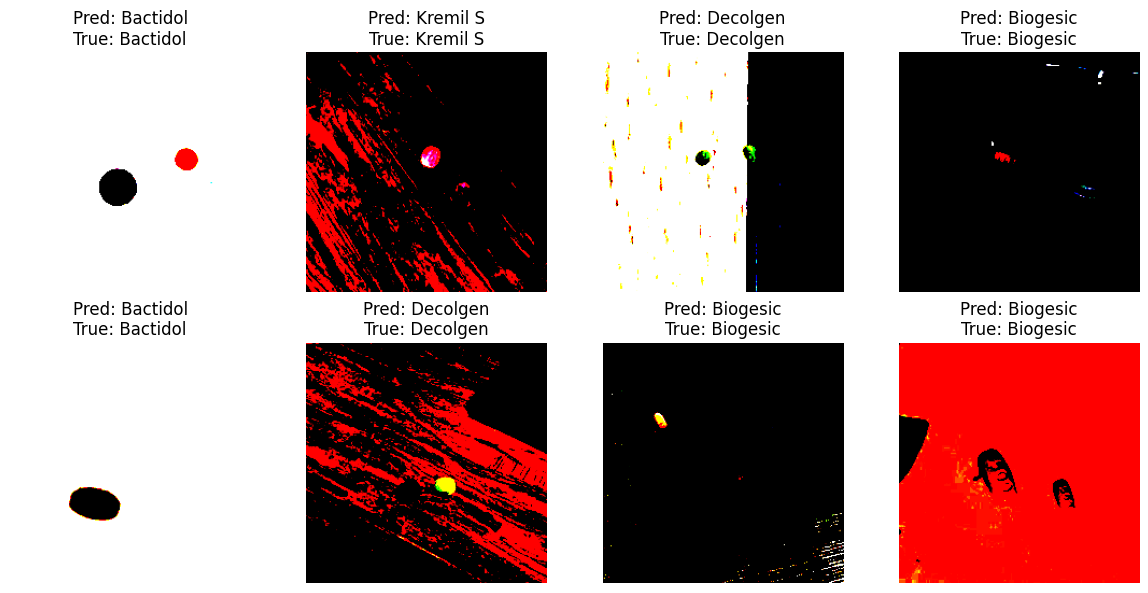

In [24]:
print(f"{best_model} F1-Score: {all_results[best_model]['f1-score']:.4f}")
#visualize predictions
print("\nVisualizing predictions for the best model:")
def display_predictions(model, num_images=8):
    model.eval()
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = plt.subplot(2, 4, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img - mean.cpu().numpy()) / std.cpu().numpy()  # Unnormalize
        plt.imshow(img)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
# Display predictions for the best model
print("\nDisplaying predictions for the best model:")
display_predictions(trained_model, num_images=8)

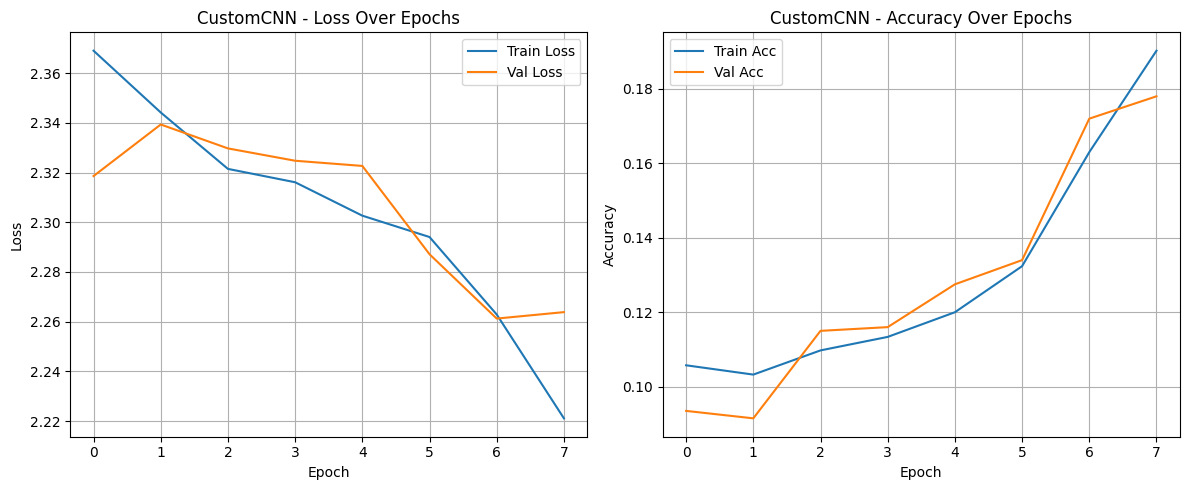

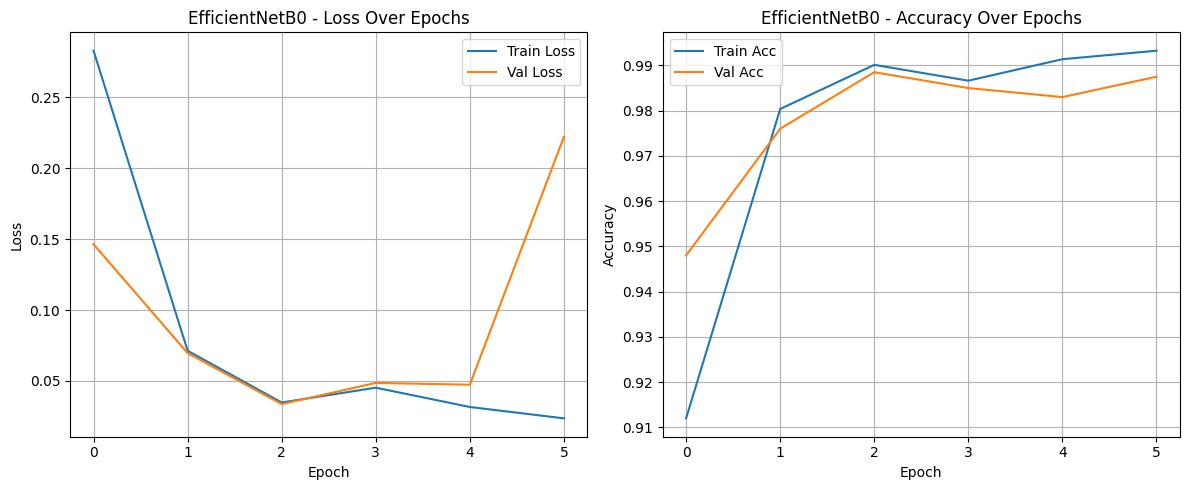

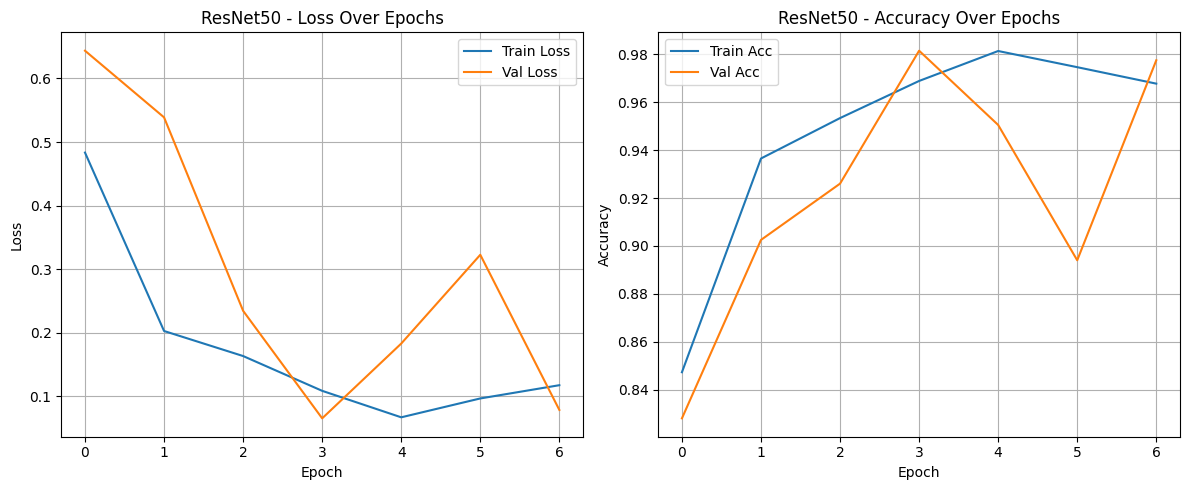

In [ ]:
# -------------------------
#Per-Model Training Curves
# -------------------------
for model_name, result in all_results.items():
    if "train_losses" in result:
        plt.figure(figsize=(12, 5))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(result["train_losses"], label="Train Loss")
        plt.plot(result["val_losses"], label="Val Loss")
        plt.title(f"{model_name} - Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(result["train_accuracies"], label="Train Acc")
        plt.plot(result["val_accuracies"], label="Val Acc")
        plt.title(f"{model_name} - Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f"{model_name}_training_curves.png")
        plt.show()
    else:
        print(f"Skipping training curves for {model_name} as it does not have training history.")

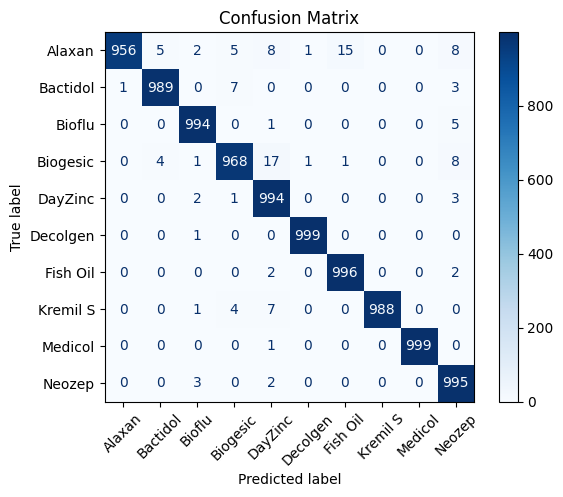

In [26]:


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

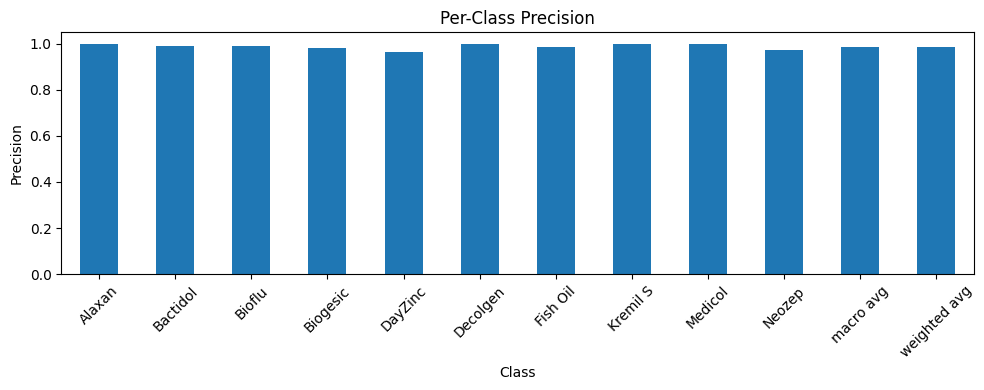

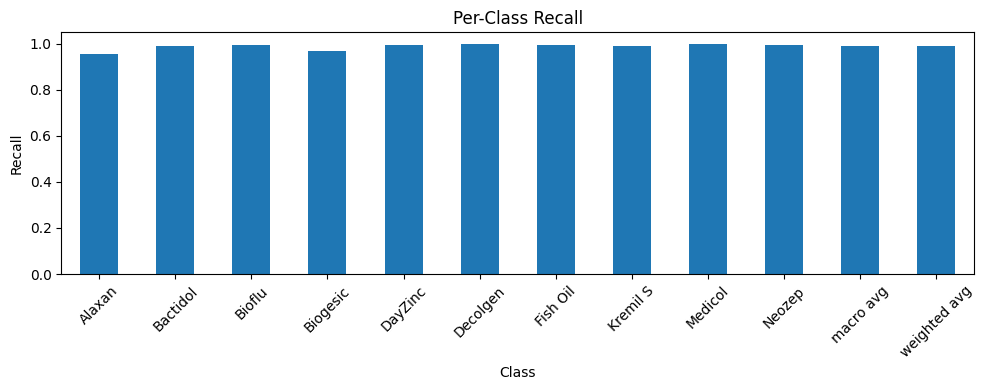

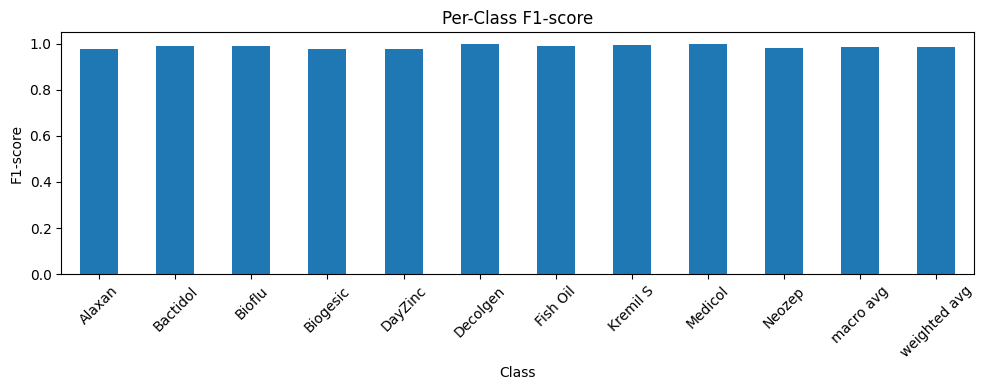

In [27]:
import pandas as pd
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose()

metrics_to_plot = ['precision', 'recall', 'f1-score']
for metric in metrics_to_plot:
    df_report[df_report.index != 'accuracy'][metric].plot(kind='bar', figsize=(10, 4), title=f'Per-Class {metric.capitalize()}')
    plt.ylabel(metric.capitalize())
    plt.xlabel("Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [35]:
#Hyperparameter Tuning for custom cnn
import itertools
from sklearn.model_selection import ParameterGrid
# Hyperparameter tuning for the improved CNN
param_grid = { 
    'learning_rate': [1e-3, 1e-4],
    'solver': ['adam', 'sgd'],
    'activation': ['relu', 'leaky_relu'],
}

In [ ]:
# -------------------------
#Define Custom CNN
# -------------------------
class ImprovedCNN(nn.Module):
    def __init__(
        self,
        num_classes,
        activation=nn.ReLU,
        num_layers=4,               
        num_filters=32,             
        kernel_size=3,              
        learning_rate=1e-3,
        solver='adam'
    ):
        super(ImprovedCNN, self).__init__()

        # Store optimizer parameters
        self.learning_rate = learning_rate
        self.solver = solver.lower()

        # Use the activation function passed in
        if activation == 'relu':
            act = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            act = nn.LeakyReLU(inplace=True)
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            act,
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            act,
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            act,
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_optimizer(self):
        """Return the optimizer object initialized with selected solver."""
        if self.solver == 'adam':
            return torch.optim.Adam(self.parameters(), lr=self.learning_rate,weight_decay=1e-5)
        elif self.solver == 'sgd':
            return torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=1e-5)
        else:
            raise ValueError(f"Unsupported optimizer: {self.solver}")

Total combinations: 8
Training with parameters: {'activation': 'relu', 'learning_rate': 0.001, 'solver': 'adam'}
Epoch 1: Train Loss=2.3623, Acc=0.1037 | Val Loss=2.3552, Acc=0.1030
Val F1 Score: 0.0758
Epoch 2: Train Loss=2.3357, Acc=0.1054 | Val Loss=2.3196, Acc=0.1235
Val F1 Score: 0.0832
Epoch 3: Train Loss=2.3141, Acc=0.1121 | Val Loss=2.3098, Acc=0.1245
Val F1 Score: 0.0837
Epoch 4: Train Loss=2.2985, Acc=0.1328 | Val Loss=2.2798, Acc=0.1595
Val F1 Score: 0.1280
Epoch 5: Train Loss=2.2629, Acc=0.1674 | Val Loss=2.2634, Acc=0.1900
Val F1 Score: 0.1345
Epoch 6: Train Loss=2.1960, Acc=0.2000 | Val Loss=2.1554, Acc=0.2380
Val F1 Score: 0.1779
Epoch 7: Train Loss=2.1157, Acc=0.2379 | Val Loss=2.0712, Acc=0.2630
Val F1 Score: 0.2399
Epoch 8: Train Loss=1.9961, Acc=0.2923 | Val Loss=1.9089, Acc=0.3410
Val F1 Score: 0.2945
Epoch 9: Train Loss=1.8379, Acc=0.3776 | Val Loss=1.9078, Acc=0.4105
Val F1 Score: 0.4079
Epoch 10: Train Loss=1.6444, Acc=0.4691 | Val Loss=1.7298, Acc=0.4425
Val F1 

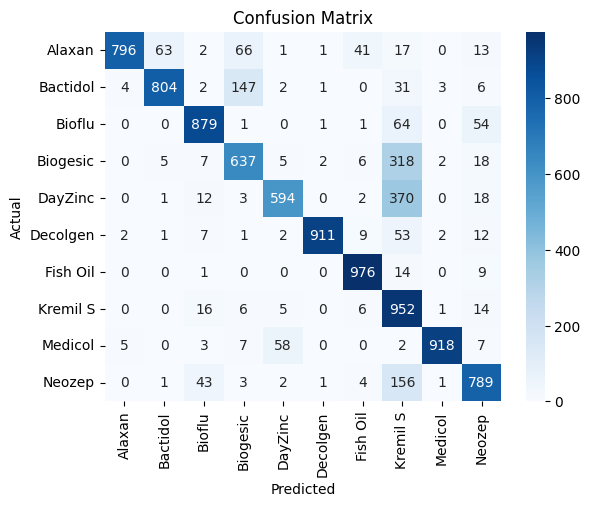

Finished training with parameters: {'activation': 'relu', 'learning_rate': 0.001, 'solver': 'adam'}

--------------------------------------------------
Training with parameters: {'activation': 'relu', 'learning_rate': 0.001, 'solver': 'sgd'}
Epoch 1: Train Loss=2.3607, Acc=0.1016 | Val Loss=2.3157, Acc=0.1170
Val F1 Score: 0.0702
Epoch 2: Train Loss=2.3193, Acc=0.1084 | Val Loss=2.2946, Acc=0.1245
Val F1 Score: 0.0899
Epoch 3: Train Loss=2.3049, Acc=0.1196 | Val Loss=2.2844, Acc=0.1560
Val F1 Score: 0.1320
Epoch 4: Train Loss=2.2867, Acc=0.1400 | Val Loss=2.2598, Acc=0.1885
Val F1 Score: 0.1638
Epoch 5: Train Loss=2.2505, Acc=0.1752 | Val Loss=2.2635, Acc=0.2040
Val F1 Score: 0.1317
Epoch 6: Train Loss=2.1703, Acc=0.2205 | Val Loss=2.2482, Acc=0.2340
Val F1 Score: 0.1779
Epoch 7: Train Loss=2.0666, Acc=0.2690 | Val Loss=1.9934, Acc=0.2980
Val F1 Score: 0.2791
Epoch 8: Train Loss=1.9298, Acc=0.3465 | Val Loss=1.8785, Acc=0.4005
Val F1 Score: 0.4198
Epoch 9: Train Loss=1.7328, Acc=0.4410

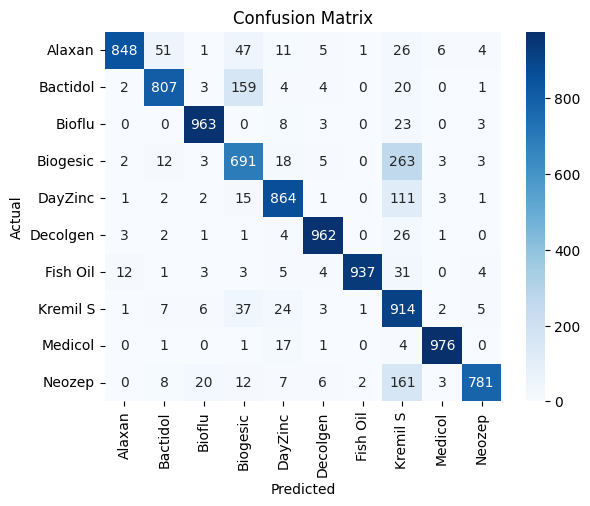

Finished training with parameters: {'activation': 'relu', 'learning_rate': 0.001, 'solver': 'sgd'}

--------------------------------------------------
Training with parameters: {'activation': 'relu', 'learning_rate': 0.0001, 'solver': 'adam'}
Epoch 1: Train Loss=2.3600, Acc=0.1089 | Val Loss=2.3028, Acc=0.1195
Val F1 Score: 0.1115
Epoch 2: Train Loss=2.3336, Acc=0.1136 | Val Loss=2.3094, Acc=0.1270
Val F1 Score: 0.1051
Epoch 3: Train Loss=2.3114, Acc=0.1210 | Val Loss=2.2875, Acc=0.1460
Val F1 Score: 0.1226
Epoch 4: Train Loss=2.3021, Acc=0.1370 | Val Loss=2.2749, Acc=0.1815
Val F1 Score: 0.1668
Epoch 5: Train Loss=2.2791, Acc=0.1524 | Val Loss=2.2847, Acc=0.1755
Val F1 Score: 0.1536
Epoch 6: Train Loss=2.2617, Acc=0.1695 | Val Loss=2.2651, Acc=0.1925
Val F1 Score: 0.1687
Epoch 7: Train Loss=2.2381, Acc=0.1928 | Val Loss=2.2275, Acc=0.2455
Val F1 Score: 0.2342
Epoch 8: Train Loss=2.2138, Acc=0.2092 | Val Loss=2.2028, Acc=0.2635
Val F1 Score: 0.2507
Epoch 9: Train Loss=2.1716, Acc=0.244

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001B46530A8E0>
Traceback (most recent call last):
  File "C:\Users\doruk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "C:\Users\doruk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001B46530A8E0>
Traceback (most recent call last):
  File "C:\Users\doruk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_q

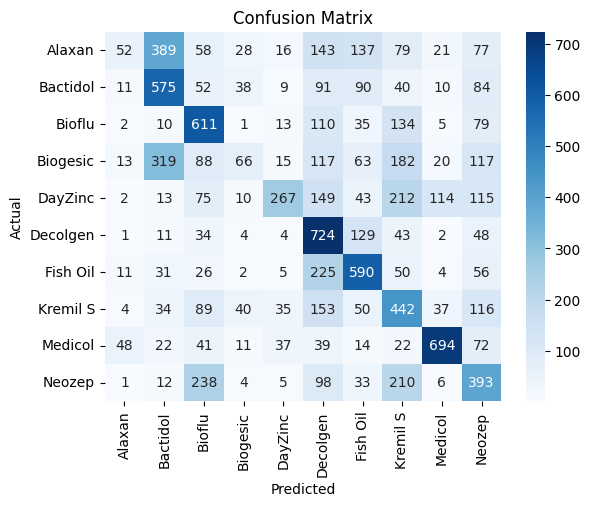

Finished training with parameters: {'activation': 'relu', 'learning_rate': 0.0001, 'solver': 'adam'}

--------------------------------------------------
Training with parameters: {'activation': 'relu', 'learning_rate': 0.0001, 'solver': 'sgd'}
Epoch 1: Train Loss=2.3505, Acc=0.1124 | Val Loss=2.3014, Acc=0.1220
Val F1 Score: 0.1106
Epoch 2: Train Loss=2.3206, Acc=0.1246 | Val Loss=2.2910, Acc=0.1295
Val F1 Score: 0.1112
Epoch 3: Train Loss=2.3118, Acc=0.1221 | Val Loss=2.2825, Acc=0.1550
Val F1 Score: 0.1321
Epoch 4: Train Loss=2.2880, Acc=0.1485 | Val Loss=2.2701, Acc=0.1890
Val F1 Score: 0.1804
Epoch 5: Train Loss=2.2734, Acc=0.1590 | Val Loss=2.2549, Acc=0.1790
Val F1 Score: 0.1584
Epoch 6: Train Loss=2.2522, Acc=0.1775 | Val Loss=2.2517, Acc=0.2050
Val F1 Score: 0.1787
Epoch 7: Train Loss=2.2314, Acc=0.1910 | Val Loss=2.2200, Acc=0.2455
Val F1 Score: 0.2322
Epoch 8: Train Loss=2.1986, Acc=0.2204 | Val Loss=2.1818, Acc=0.2705
Val F1 Score: 0.2436
Epoch 9: Train Loss=2.1559, Acc=0.24

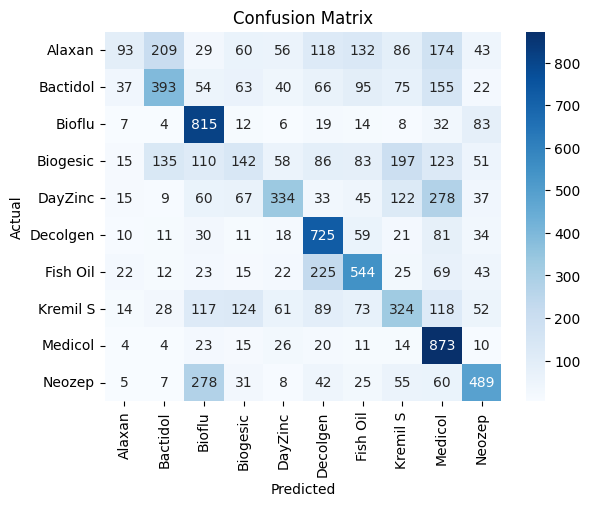

Finished training with parameters: {'activation': 'relu', 'learning_rate': 0.0001, 'solver': 'sgd'}

--------------------------------------------------
Training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.001, 'solver': 'adam'}
Epoch 1: Train Loss=2.3598, Acc=0.1037 | Val Loss=2.3166, Acc=0.0980
Val F1 Score: 0.0611
Epoch 2: Train Loss=2.3361, Acc=0.1036 | Val Loss=2.3201, Acc=0.0925
Val F1 Score: 0.0524
Epoch 3: Train Loss=2.3206, Acc=0.1129 | Val Loss=2.3115, Acc=0.0990
Val F1 Score: 0.0467
Epoch 4: Train Loss=2.3070, Acc=0.1194 | Val Loss=2.7778, Acc=0.1465
Val F1 Score: 0.0810
Epoch 5: Train Loss=2.2652, Acc=0.1515 | Val Loss=2.2479, Acc=0.1630
Val F1 Score: 0.1275
Epoch 6: Train Loss=2.2182, Acc=0.1721 | Val Loss=2.1736, Acc=0.1725
Val F1 Score: 0.1286
Epoch 7: Train Loss=2.1638, Acc=0.2039 | Val Loss=2.1212, Acc=0.2185
Val F1 Score: 0.1730
Epoch 8: Train Loss=2.0937, Acc=0.2261 | Val Loss=2.0064, Acc=0.3185
Val F1 Score: 0.2879
Epoch 9: Train Loss=1.9934, Acc

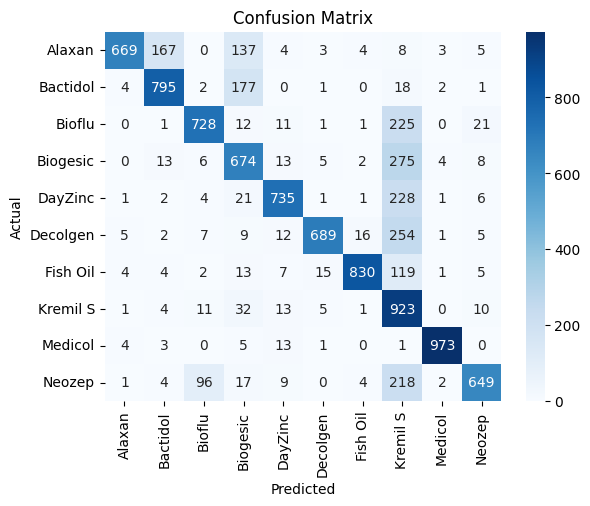

Finished training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.001, 'solver': 'adam'}

--------------------------------------------------
Training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.001, 'solver': 'sgd'}
Epoch 1: Train Loss=2.3694, Acc=0.1006 | Val Loss=2.3124, Acc=0.1015
Val F1 Score: 0.0545
Epoch 2: Train Loss=2.3268, Acc=0.1079 | Val Loss=2.3168, Acc=0.1130
Val F1 Score: 0.0792
Epoch 3: Train Loss=2.3116, Acc=0.1131 | Val Loss=2.2952, Acc=0.1170
Val F1 Score: 0.0795
Epoch 4: Train Loss=2.2989, Acc=0.1261 | Val Loss=2.2814, Acc=0.1500
Val F1 Score: 0.1169
Epoch 5: Train Loss=2.2802, Acc=0.1454 | Val Loss=2.2915, Acc=0.1555
Val F1 Score: 0.0852
Epoch 6: Train Loss=2.2288, Acc=0.1859 | Val Loss=2.1795, Acc=0.1845
Val F1 Score: 0.1415
Epoch 7: Train Loss=2.1389, Acc=0.2309 | Val Loss=2.1346, Acc=0.2550
Val F1 Score: 0.2383
Epoch 8: Train Loss=2.0412, Acc=0.2787 | Val Loss=2.0115, Acc=0.3045
Val F1 Score: 0.2961
Epoch 9: Train Loss=1.9080

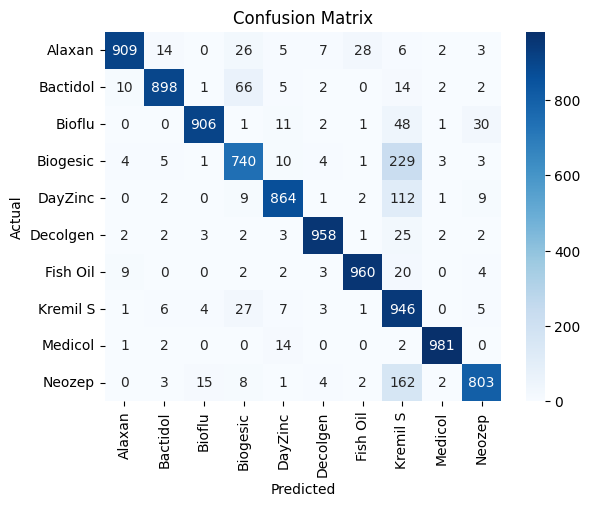

Finished training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.001, 'solver': 'sgd'}

--------------------------------------------------
Training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.0001, 'solver': 'adam'}
Epoch 1: Train Loss=2.3492, Acc=0.1109 | Val Loss=2.3035, Acc=0.1145
Val F1 Score: 0.0963
Epoch 2: Train Loss=2.3256, Acc=0.1158 | Val Loss=2.2949, Acc=0.1280
Val F1 Score: 0.1072
Epoch 3: Train Loss=2.3021, Acc=0.1320 | Val Loss=2.2802, Acc=0.1540
Val F1 Score: 0.1487
Epoch 4: Train Loss=2.2887, Acc=0.1399 | Val Loss=2.2744, Acc=0.1470
Val F1 Score: 0.1342
Epoch 5: Train Loss=2.2727, Acc=0.1570 | Val Loss=2.2649, Acc=0.1775
Val F1 Score: 0.1583
Epoch 6: Train Loss=2.2549, Acc=0.1761 | Val Loss=2.2574, Acc=0.2015
Val F1 Score: 0.1912
Epoch 7: Train Loss=2.2394, Acc=0.1913 | Val Loss=2.2330, Acc=0.2245
Val F1 Score: 0.1974
Epoch 8: Train Loss=2.2116, Acc=0.2112 | Val Loss=2.2094, Acc=0.2380
Val F1 Score: 0.2190
Epoch 9: Train Loss=2.182

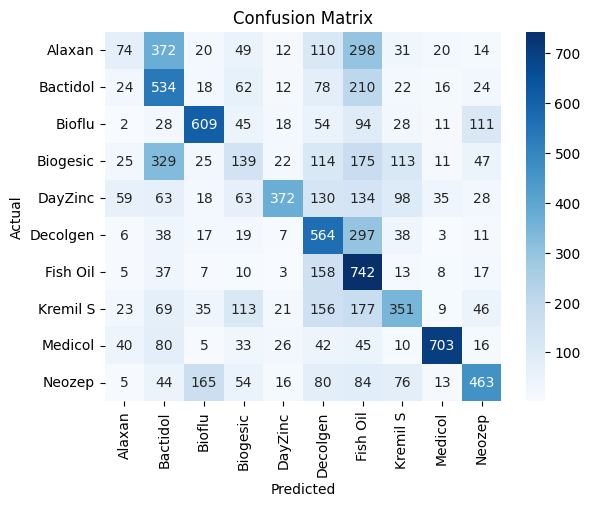

Finished training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.0001, 'solver': 'adam'}

--------------------------------------------------
Training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.0001, 'solver': 'sgd'}
Epoch 1: Train Loss=2.3590, Acc=0.1044 | Val Loss=2.3072, Acc=0.1305
Val F1 Score: 0.1013
Epoch 2: Train Loss=2.3235, Acc=0.1168 | Val Loss=2.2998, Acc=0.1400
Val F1 Score: 0.1165
Epoch 3: Train Loss=2.3076, Acc=0.1268 | Val Loss=2.2888, Acc=0.1475
Val F1 Score: 0.1392
Epoch 4: Train Loss=2.2952, Acc=0.1410 | Val Loss=2.2700, Acc=0.1665
Val F1 Score: 0.1566
Epoch 5: Train Loss=2.2741, Acc=0.1568 | Val Loss=2.2730, Acc=0.1680
Val F1 Score: 0.1555
Epoch 6: Train Loss=2.2549, Acc=0.1725 | Val Loss=2.2474, Acc=0.1865
Val F1 Score: 0.1734
Epoch 7: Train Loss=2.2313, Acc=0.1890 | Val Loss=2.2216, Acc=0.2265
Val F1 Score: 0.2185
Epoch 8: Train Loss=2.2103, Acc=0.2070 | Val Loss=2.2100, Acc=0.2175
Val F1 Score: 0.1972
Epoch 9: Train Loss=2.17

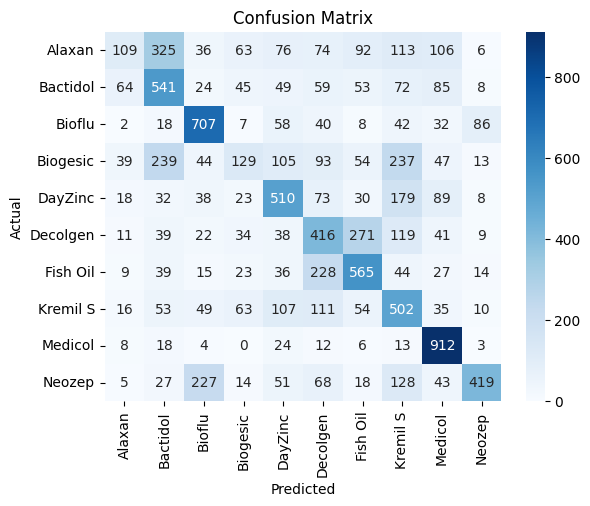

Finished training with parameters: {'activation': 'leaky_relu', 'learning_rate': 0.0001, 'solver': 'sgd'}

--------------------------------------------------


In [44]:
# Create a grid of hyperparameters
grid = ParameterGrid(param_grid)
print(f"Total combinations: {len(grid)}")
# Iterate through each combination of hyperparameters
for params in grid:
    print(f"Training with parameters: {params}")
    model = ImprovedCNN(num_classes=len(class_names), **params).to(device)
    
    # Train the model
    trained_model, history = train_model(
        model,
        train_loader=train_loader,
        val_loader=val_loader,
        class_names=class_names,
        device=device,
        epochs=15,  
        lr=params['learning_rate']
    )
    
    # Evaluate the model
    evaluate_model(trained_model)
    print(f"Finished training with parameters: {params}\n")
    print("-" * 50)

# Save the best model
torch.save(trained_model.state_dict(), "best_improved_cnn.pth")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-41.14164..18.445944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.98915..18.845865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-25.237686..24.559942].


Best model parameters: {'solver': 'sgd', 'learning_rate': 0.001, 'activation': 'leaky_relu'}

Displaying predictions for the best model:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-32.277054..15.3442955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-43.185978..-2.2942727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-43.185978..15.920046].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-39.64972..25.382128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-39.838036..20.946808].


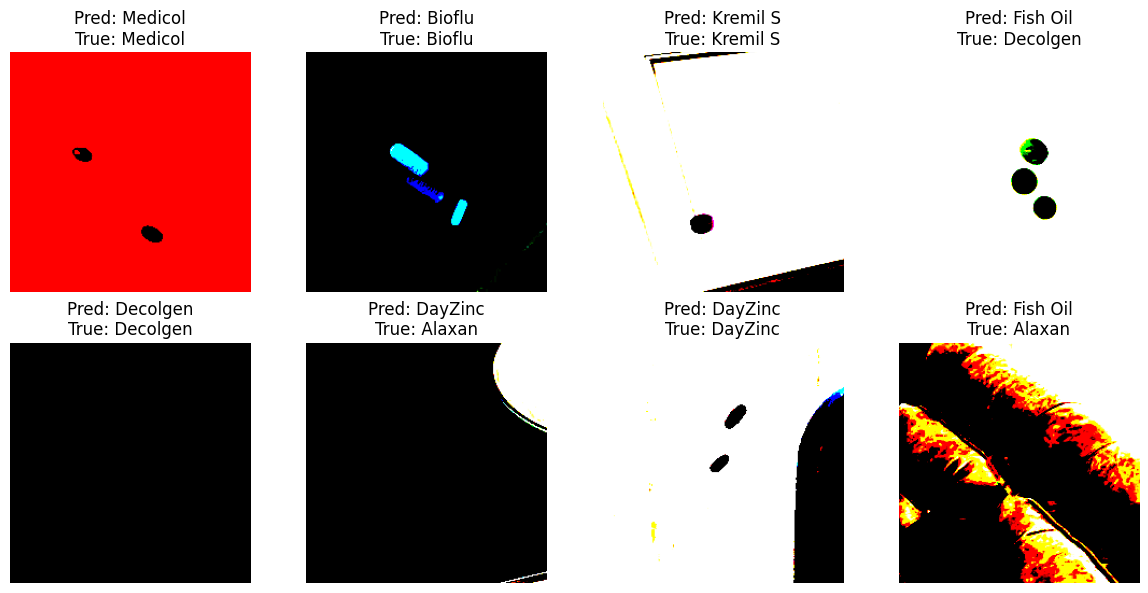

In [86]:
#import best model
best_model = ImprovedCNN(num_classes=len(class_names), **grid[5]).to(device)
best_model.load_state_dict(torch.load("best_improved_cnn.pth"))
print(f"Best model parameters: {grid[5]}")
#copilot help
# Display predictions for the best model
print("\nDisplaying predictions for the best model:")
display_predictions(best_model, num_images=8)

